# Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, GlobalAveragePooling2D, LeakyReLU, ReLU, AveragePooling2D,  Add, Reshape, UpSampling2D, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam, RMSprop # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


# LIGTH + PRO

Решил совместить лайт и про и сделать PSPnet с разными параметрам, попутно пытаясь добиться лучшей точности

## Загрузка картинок

*Разбор данного раздела:* https://youtu.be/PCTynVb9TbI?t=1651

In [ ]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
num_classes = 6 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/25 сегментация изображений/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка' # Название папки с файлами проверочной выборки

### Оригинальные изображения

*Разбор данного раздела:* https://youtu.be/PCTynVb9TbI?t=1778

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути     
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images)) # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути                  
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images)) # Отображаем количество элементов в проверочной выборке

Обучающая выборка загржуена. Время загрузки: 13.46c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 0.71c
Количество изображений:  50


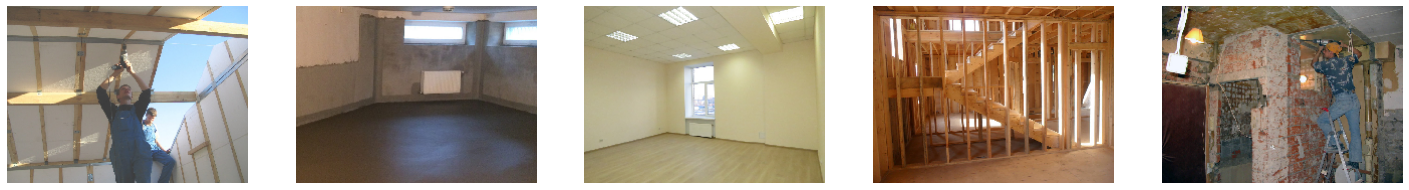

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 10)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_images) # Выбираем случайное фото для отображения
  axs[i].axis('off')
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

### Сегментированные изображения

*Разбор данного раздела:* https://youtu.be/PCTynVb9TbI?t=1875

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загржуена. Время загрузки: 129.58c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 11.37c
Количество изображений:  50


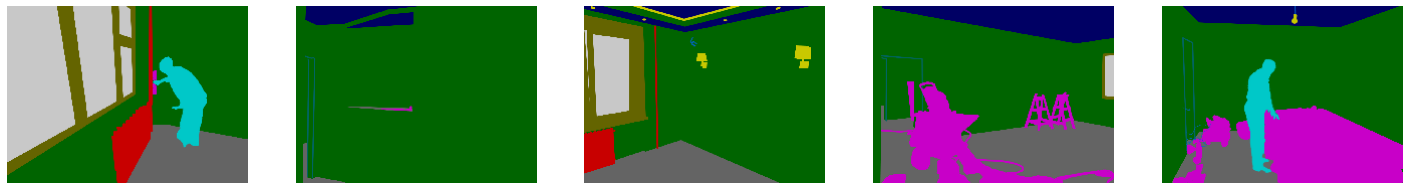

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 10)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_segments) # Выбираем случайное фото для отображения
  axs[i].axis('off')
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Создание выборки

*Разбор данного раздела:* https://youtu.be/PCTynVb9TbI?t=1912

In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=0 # пол

  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=1 # внешний мир

  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=2 # батарея
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=3 # люди
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4 # источники света
  else: index=5
  return index  

In [ ]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # внешний мир
  elif index == 2: color = [0, 100, 0]  # батарея
  elif index == 3: color = [100, 0, 0]  # люди
  elif index == 4: color = [0, 100, 100]  # источники света
  elif index == 5: color = [0, 0, 0]  # остальное
  return color # Возвращаем цвет пикслея

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  1174.6 c


In [ ]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

Время обработки:  60.03 c


In [ ]:
yTrain.shape

(900, 176, 240, 6)

In [ ]:
np.save('/content/drive/My Drive/25 сегментация изображений/xTrain.npy',xTrain)
np.save('/content/drive/My Drive/25 сегментация изображений/xVal.npy',xVal)
np.save('/content/drive/My Drive/25 сегментация изображений/yTrain.npy',yTrain)
np.save('/content/drive/My Drive/25 сегментация изображений/yVal.npy',yVal)

In [ ]:
xTrain = np.load('/content/drive/My Drive/25 сегментация изображений/xTrain.npy')
xVal = np.load('/content/drive/My Drive/25 сегментация изображений/xVal.npy')
yTrain = np.load('/content/drive/My Drive/25 сегментация изображений/yTrain.npy')
yVal = np.load('/content/drive/My Drive/25 сегментация изображений/yVal.npy')

## PSP-net


Взял 1 классическую модель, менял оптимайзеры, добавлял количество фильтров в свертках, менял батч_сайзы (тут особо не разгуляешься, так как с этой архитектурой большой батчсайз не влазит в память gpu), менял с leakyrelu на просто relu

лучший результат - 75.15 dice_coef на проверочной выборке - получился на модели с увеличенным количеством фильтров на свертках и с активацией через ReLU. Хотя данный результат очень близок к результатам обычной модели pspnet (там получалось порядка 74.84).
Лучшая модель расположена внизу ноутбука


In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
# коллбек с сохрананием
checkpoint_filepath = '/content/drive/My Drive/25 сегментация изображений/saves/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)

In [ ]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    print(input_layer.shape)
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    print(base.shape)
    base = conv_block(base,[64,64,128],'2')
    # block_3
    print(base.shape)

    base = conv_block(base,[128,128,256],'3')
    print(base.shape)

    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red =  AveragePooling2D(name='red_pool')(base)
    # red = Reshape((1,1,256))(red)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=2,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = MaxPooling2D(pool_size=(2,2),name='yellow_pool')(base)
    # yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = MaxPooling2D(pool_size=(4,4),name='blue_pool')(base)
    # blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = MaxPooling2D(pool_size=(8,8),name='green_pool')(base)
    # green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer, num_classes):
    X = pyramid_feature_maps(input_layer)
    X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    # X = Activation('sigmoid',name='last_conv_relu')(X)
    X = Activation('relu')(X)                                          # Добавляем слой Activation

    X = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(X)
    # X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X

In [ ]:
xTrain[0].shape

(176, 240, 3)

In [ ]:
input_layer = Input(shape=np.squeeze(xTrain[0]).shape,name='input')
output_layer = last_conv_module(input_layer, num_classes)
model = Model(inputs=input_layer,outputs=output_layer)

(None, 176, 240, 3)
(None, 176, 240, 64)
(None, 176, 240, 128)
(None, 176, 240, 256)


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block_1_a (Conv2D)              (None, 176, 240, 32) 128         input[0][0]                      
__________________________________________________________________________________________________
block_1_batch_norm_a (BatchNorm (None, 176, 240, 32) 128         block_1_a[0][0]                  
__________________________________________________________________________________________________
block_1_leakyrelu_a (LeakyReLU) (None, 176, 240, 32) 0           block_1_batch_norm_a[0][0]       
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

In [ ]:
history = model.fit(xTrain, yTrain, epochs=100, batch_size=16, validation_data=(xVal, yVal),
                    callbacks = [model_checkpoint_callback])

Epoch 1/100
57/57 [==============================] - 32s 560ms/step - loss: 0.0886 - dice_coef: 0.9541 - val_loss: 2.6669 - val_dice_coef: 0.6364
Epoch 2/100
57/57 [==============================] - 32s 559ms/step - loss: 0.0876 - dice_coef: 0.9542 - val_loss: 2.6265 - val_dice_coef: 0.6390
Epoch 3/100
57/57 [==============================] - 32s 558ms/step - loss: 0.0869 - dice_coef: 0.9548 - val_loss: 2.2973 - val_dice_coef: 0.6825
Epoch 4/100
57/57 [==============================] - 32s 558ms/step - loss: 0.0850 - dice_coef: 0.9546 - val_loss: 1.5976 - val_dice_coef: 0.6484
Epoch 5/100
57/57 [==============================] - 32s 558ms/step - loss: 0.0860 - dice_coef: 0.9555 - val_loss: 1.4632 - val_dice_coef: 0.7186
Epoch 6/100
57/57 [==============================] - 32s 559ms/step - loss: 0.0876 - dice_coef: 0.9543 - val_loss: 2.1179 - val_dice_coef: 0.6758
Epoch 7/100
57/57 [==============================] - 32s 559ms/step - loss: 0.0856 - dice_coef: 0.9548 - val_loss: 2.4656 - 

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
# меняем оптимайзер на РМСпроп снимажем lr

model.compile(optimizer=RMSprop(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

In [ ]:
# пробуем дообучить модель
history = model.fit(xTrain, yTrain, epochs=100, batch_size=16, validation_data=(xVal, yVal),
                    callbacks = [model_checkpoint_callback])

Epoch 1/100
57/57 [==============================] - 34s 589ms/step - loss: 0.0726 - dice_coef: 0.9619 - val_loss: 1.4976 - val_dice_coef: 0.6990
Epoch 2/100
57/57 [==============================] - 32s 564ms/step - loss: 0.0702 - dice_coef: 0.9626 - val_loss: 1.7498 - val_dice_coef: 0.7095
Epoch 3/100
57/57 [==============================] - 32s 559ms/step - loss: 0.0706 - dice_coef: 0.9621 - val_loss: 1.9933 - val_dice_coef: 0.6814
Epoch 4/100
57/57 [==============================] - 32s 561ms/step - loss: 0.0680 - dice_coef: 0.9641 - val_loss: 1.9466 - val_dice_coef: 0.7229
Epoch 5/100
57/57 [==============================] - 32s 559ms/step - loss: 0.0701 - dice_coef: 0.9632 - val_loss: 1.8180 - val_dice_coef: 0.6766
Epoch 6/100
57/57 [==============================] - 32s 559ms/step - loss: 0.0712 - dice_coef: 0.9620 - val_loss: 1.7407 - val_dice_coef: 0.6847
Epoch 7/100
57/57 [==============================] - 32s 559ms/step - loss: 0.0707 - dice_coef: 0.9628 - val_loss: 3.7770 - 

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    axs[2,i].axis('off')
  plt.show()  

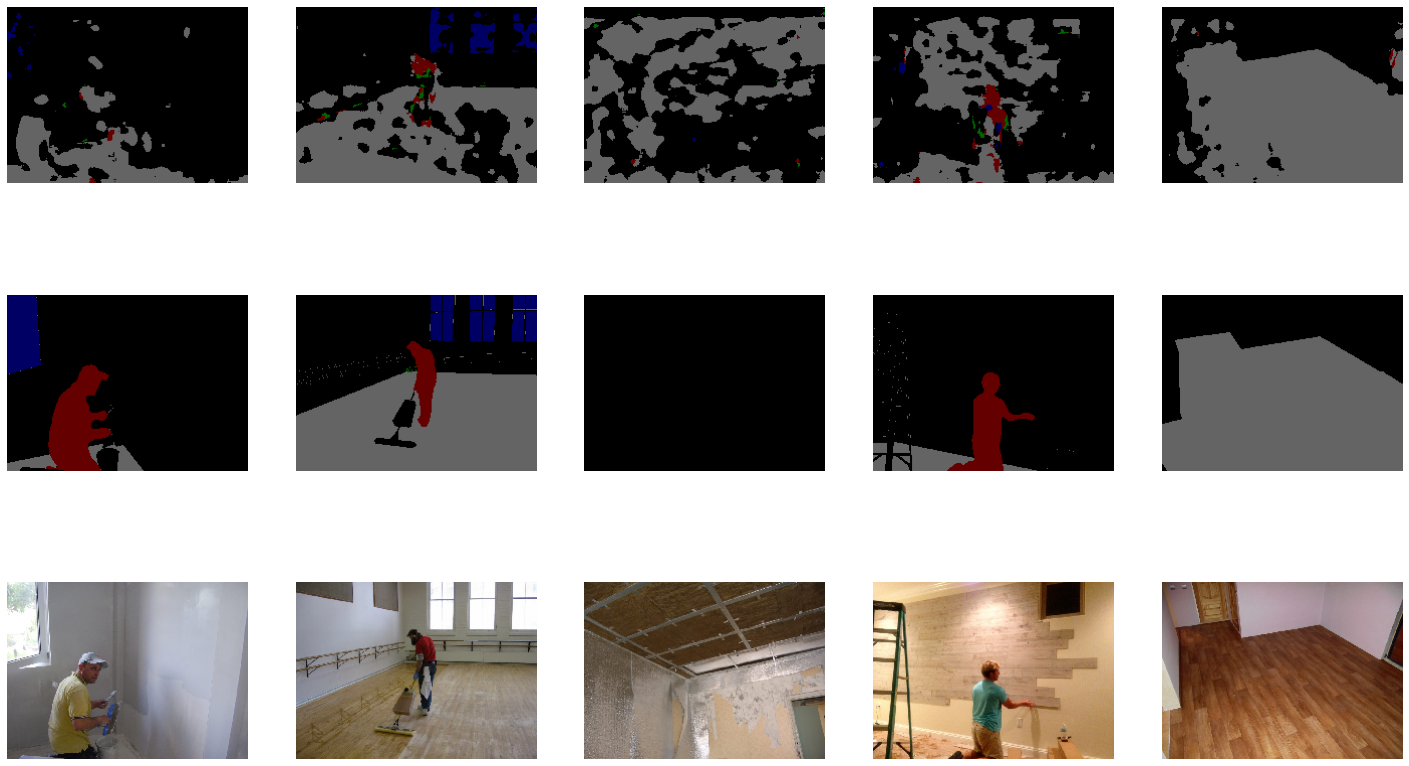

In [ ]:
processImage(model, 5, num_classes)

## Увеличиваем количество фильтров в свертках + снижаем batch_size

In [ ]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    print(input_layer.shape)
    base = conv_block(input_layer,[32,64,128],'1')
    # block_2
    print(base.shape)
    base = conv_block(base,[64,128,256],'2')
    # block_3
    print(base.shape)

    base = conv_block(base,[128,256,512],'3')
    print(base.shape)

    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red =  AveragePooling2D(name='red_pool')(base)
    # red = Reshape((1,1,256))(red)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=2,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = MaxPooling2D(pool_size=(2,2),name='yellow_pool')(base)
    # yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = MaxPooling2D(pool_size=(4,4),name='blue_pool')(base)
    # blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = MaxPooling2D(pool_size=(8,8),name='green_pool')(base)
    # green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer, num_classes):
    X = pyramid_feature_maps(input_layer)
    # X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    # X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    # # X = Activation('sigmoid',name='last_conv_relu')(X)
    # X = Activation('relu')(X)                                          # Добавляем слой Activation

    X = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(X)
    # X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X

In [ ]:
xTrain[0].shape

(176, 240, 3)

In [ ]:
input_layer = Input(shape=np.squeeze(xTrain[0]).shape,name='input')
output_layer = last_conv_module(input_layer, num_classes)
model = Model(inputs=input_layer,outputs=output_layer)

(None, 176, 240, 3)
(None, 176, 240, 128)
(None, 176, 240, 256)
(None, 176, 240, 512)


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block_1_a (Conv2D)              (None, 176, 240, 32) 128         input[0][0]                      
__________________________________________________________________________________________________
block_1_batch_norm_a (BatchNorm (None, 176, 240, 32) 128         block_1_a[0][0]                  
__________________________________________________________________________________________________
block_1_leakyrelu_a (LeakyReLU) (None, 176, 240, 32) 0           block_1_batch_norm_a[0][0]       
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

In [ ]:
history = model.fit(xTrain, yTrain, epochs=150, batch_size=8, validation_data=(xVal, yVal),
                    callbacks = [model_checkpoint_callback])

Epoch 1/150
113/113 [==============================] - 69s 608ms/step - loss: 0.4268 - dice_coef: 0.7674 - val_loss: 0.8846 - val_dice_coef: 0.6442
Epoch 2/150
113/113 [==============================] - 69s 608ms/step - loss: 0.4288 - dice_coef: 0.7641 - val_loss: 0.8176 - val_dice_coef: 0.6372
Epoch 3/150
113/113 [==============================] - 69s 607ms/step - loss: 0.4244 - dice_coef: 0.7677 - val_loss: 0.8305 - val_dice_coef: 0.6360
Epoch 4/150
113/113 [==============================] - 69s 609ms/step - loss: 0.4189 - dice_coef: 0.7724 - val_loss: 0.7831 - val_dice_coef: 0.6578
Epoch 5/150
113/113 [==============================] - 69s 608ms/step - loss: 0.4186 - dice_coef: 0.7718 - val_loss: 0.8216 - val_dice_coef: 0.6330
Epoch 6/150
113/113 [==============================] - 69s 609ms/step - loss: 0.4047 - dice_coef: 0.7787 - val_loss: 0.7437 - val_dice_coef: 0.6762
Epoch 7/150
113/113 [==============================] - 69s 608ms/step - loss: 0.4147 - dice_coef: 0.7740 - val_l

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

In [ ]:
# Пробуем дообучить с другим обптимайзером и шагом
history = model.fit(xTrain, yTrain, epochs=20, batch_size=8, validation_data=(xVal, yVal),
                    callbacks = [model_checkpoint_callback])

Epoch 1/20
113/113 [==============================] - 69s 612ms/step - loss: 0.0321 - dice_coef: 0.9827 - val_loss: 1.5237 - val_dice_coef: 0.7373
Epoch 2/20
113/113 [==============================] - 69s 609ms/step - loss: 0.0293 - dice_coef: 0.9843 - val_loss: 1.5566 - val_dice_coef: 0.7350
Epoch 3/20
113/113 [==============================] - 69s 609ms/step - loss: 0.0287 - dice_coef: 0.9846 - val_loss: 1.5728 - val_dice_coef: 0.7340
Epoch 4/20
113/113 [==============================] - 69s 609ms/step - loss: 0.0284 - dice_coef: 0.9848 - val_loss: 1.5853 - val_dice_coef: 0.7343
Epoch 5/20
113/113 [==============================] - 69s 609ms/step - loss: 0.0280 - dice_coef: 0.9851 - val_loss: 1.5926 - val_dice_coef: 0.7330
Epoch 6/20
113/113 [==============================] - 69s 610ms/step - loss: 0.0278 - dice_coef: 0.9852 - val_loss: 1.5995 - val_dice_coef: 0.7331
Epoch 7/20
113/113 [==============================] - 69s 609ms/step - loss: 0.0271 - dice_coef: 0.9855 - val_loss: 1.

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    axs[2,i].axis('off')
  plt.show()  

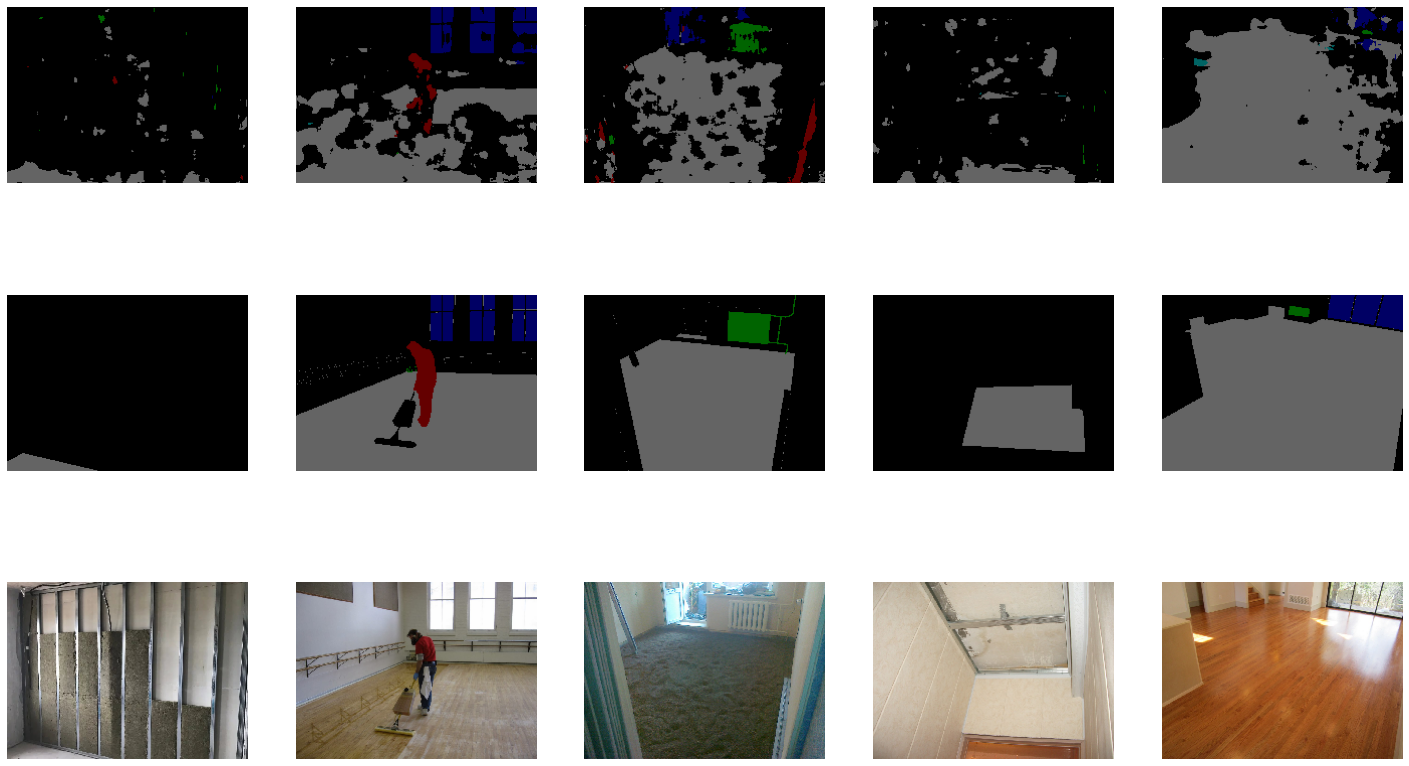

In [ ]:
processImage(model, 5, num_classes)

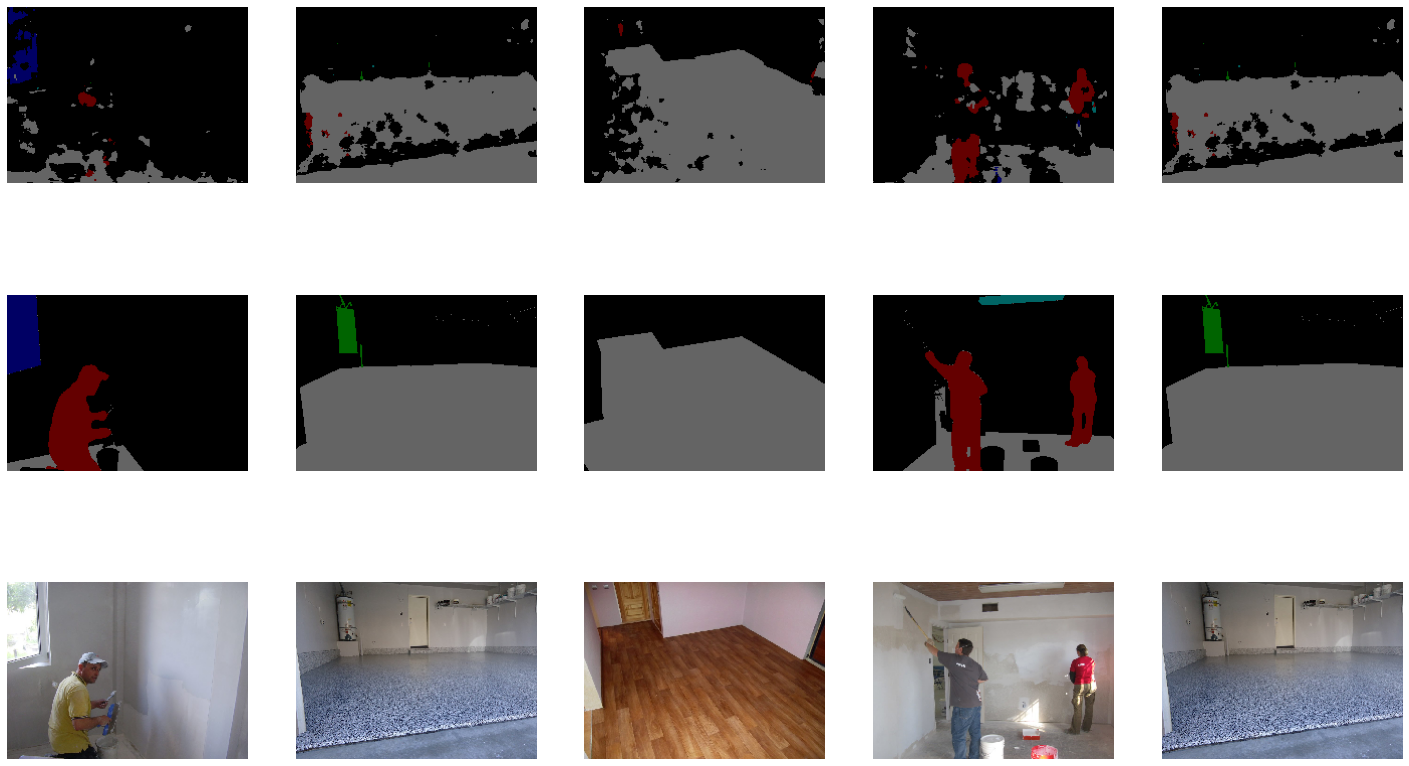

In [ ]:
processImage(model, 5, num_classes)

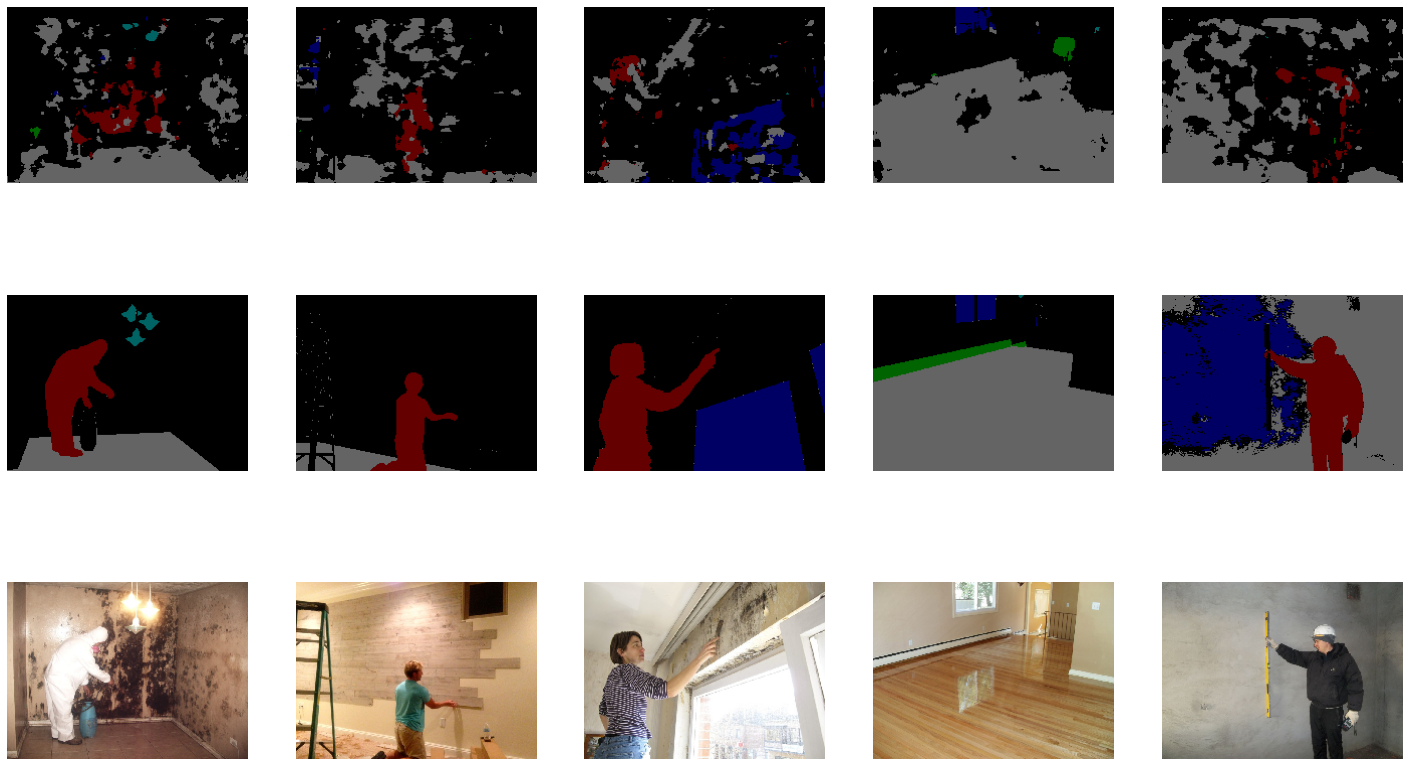

In [ ]:
processImage(model, 5, num_classes)

## Активация - RelU 

In [ ]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = ReLU(name=b+'leakyrelu_a')(X)
    # block_b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = ReLU(name=b+'leakyrelu_b')(X)
    # block_c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    print(input_layer.shape)
    base = conv_block(input_layer,[32,64,128],'1')
    # block_2
    print(base.shape)
    base = conv_block(base,[64,128,256],'2')
    # block_3
    print(base.shape)

    base = conv_block(base,[128,256,512],'3')
    print(base.shape)

    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red =  AveragePooling2D(name='red_pool')(base)
    # red = Reshape((1,1,256))(red)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = ReLU(name='leakyrelu_r')(red)
    red = UpSampling2D(size=2,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = MaxPooling2D(pool_size=(2,2),name='yellow_pool')(base)
    # yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = ReLU(name='leakyrelu_y')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = MaxPooling2D(pool_size=(4,4),name='blue_pool')(base)
    # blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = ReLU(name='leakyrelu_b')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = MaxPooling2D(pool_size=(8,8),name='green_pool')(base)
    # green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = ReLU(name='leakyrelu_g')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer, num_classes):
    X = pyramid_feature_maps(input_layer)
    # X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    # X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    # # X = Activation('sigmoid',name='last_conv_relu')(X)
    X = Activation('relu')(X)                                          # Добавляем слой Activation

    X = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(X)
    # X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X

In [ ]:
input_layer = Input(shape=np.squeeze(xTrain[0]).shape,name='input')
output_layer = last_conv_module(input_layer, num_classes)
model = Model(inputs=input_layer,outputs=output_layer)

(None, 176, 240, 3)
(None, 176, 240, 128)
(None, 176, 240, 256)
(None, 176, 240, 512)


In [ ]:
model.load_weights(checkpoint_filepath)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a4405a438> and <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7f6a4402fc50>).


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

In [ ]:
history = model.fit(xTrain, yTrain, epochs=100, batch_size=8, validation_data=(xVal, yVal),
                    callbacks = [model_checkpoint_callback])

Epoch 1/100
113/113 [==============================] - 71s 629ms/step - loss: 0.1462 - dice_coef: 0.9239 - val_loss: 1.5813 - val_dice_coef: 0.6613
Epoch 2/100
113/113 [==============================] - 69s 609ms/step - loss: 0.0583 - dice_coef: 0.9688 - val_loss: 1.5182 - val_dice_coef: 0.7057
Epoch 3/100
113/113 [==============================] - 69s 610ms/step - loss: 0.0566 - dice_coef: 0.9701 - val_loss: 1.4140 - val_dice_coef: 0.7515
Epoch 4/100
113/113 [==============================] - 69s 608ms/step - loss: 0.0600 - dice_coef: 0.9681 - val_loss: 1.3759 - val_dice_coef: 0.7358
Epoch 5/100
113/113 [==============================] - 69s 608ms/step - loss: 0.0472 - dice_coef: 0.9752 - val_loss: 1.4954 - val_dice_coef: 0.7268
Epoch 6/100
113/113 [==============================] - 69s 608ms/step - loss: 0.0475 - dice_coef: 0.9750 - val_loss: 1.5956 - val_dice_coef: 0.7136
Epoch 7/100
113/113 [==============================] - 69s 608ms/step - loss: 0.0599 - dice_coef: 0.9687 - val_l

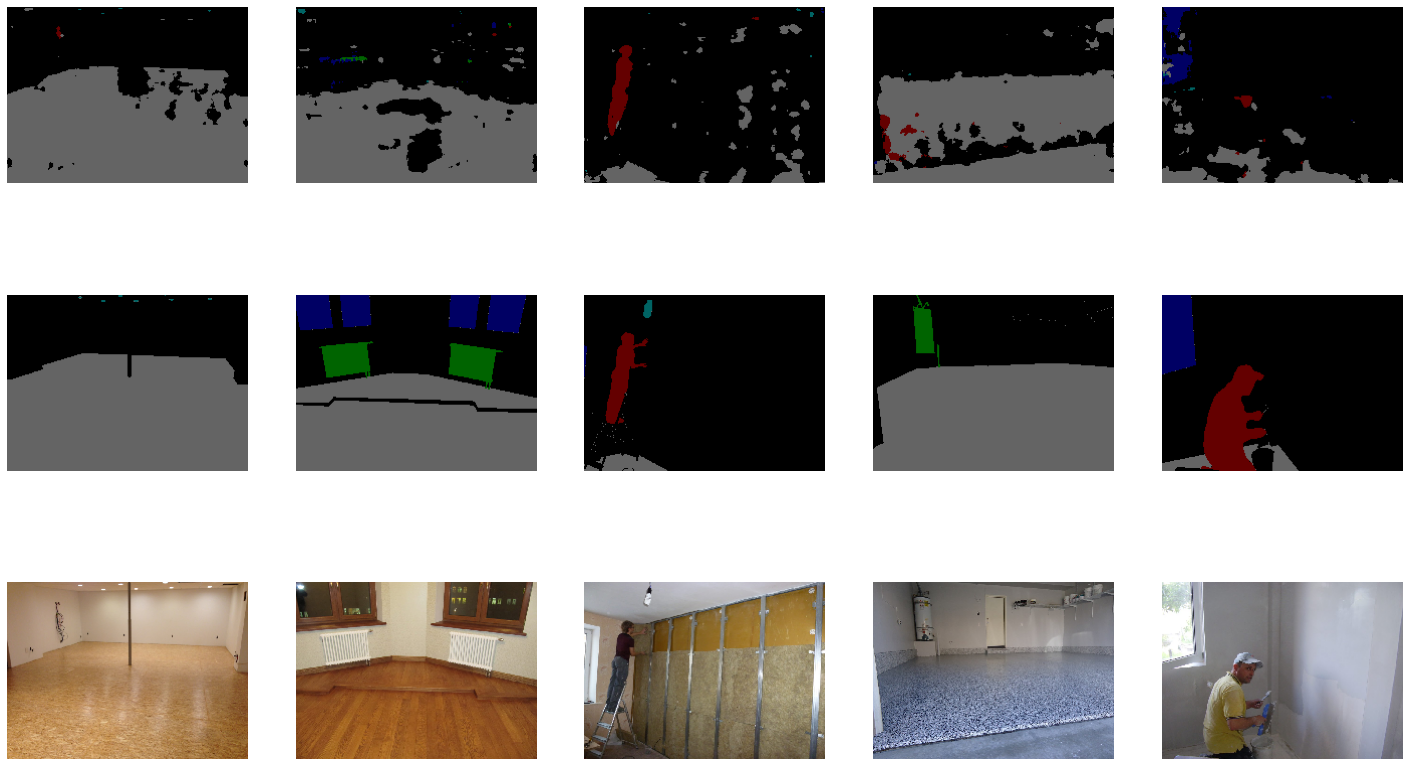

In [ ]:
processImage(model, 5, num_classes)

# Выводы

PSPnet показала худшие результаты по сравнению с Unet, но получилось добиться минимального отставания. МОжно еще эксперементировать с увеличением количества пулинг-блоков с различными параметрами (но с таким количеством параметров колабу уже плохо). 

В условиях такой нагруженной модели батч_сайз приходится выбирать минимальный, чтобы хватало памяти в gpu

Эксперименты с разными активациями и оптимайзерами не дали значительного выигрыша - значения dice_coef были примерно на одном уровне